# Agentes en LangGraph con Gemini


## Caso 2 Encadenamiento de Prompts

<img src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/prompt_chain.png" alt="gate" width="600"/>


En el Encadenamiento de Prompts (prompt chaining) cada llamada LLM procesa la salida de la anterior. En el Encadenamiento de Prompts se descompone una tarea en una secuencia de pasos, donde cada llamada LLM procesa el resultado de la anterior. Se pueden añadir comprobaciones programáticas en cualquier paso intermedio para garantizar que el proceso siga su curso.

Cuándo usar este flujo de trabajo: Este flujo de trabajo es ideal para situaciones en las que la tarea se puede descomponer de forma fácil y ordenada en subtareas fijas. El objetivo principal es compensar la latencia con una mayor precisión, simplificando cada llamada LLM.


In [11]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [12]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

# Declaración y llamado de la key del modelo LLM
# use esta función para definir la key del modelo LLM si tuvo problemas con el archivo .env.json o create_env.py
def _set_env(var: str):
   if not os.environ.get(var):
       os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

### ¿Qué es `State` y qué función cumple en el grafo?

`State` es una estructura de datos (en este caso, un `TypedDict`) que define las variables o información que se va a compartir y transformar a lo largo de los diferentes pasos (nodos) del grafo. 

En el contexto de un grafo de procesamiento (como los de LangGraph), el `State` actúa como el "estado global" que se va actualizando y pasando de un nodo a otro. Cada nodo puede leer y modificar partes del `State` según la lógica que implemente.

Por ejemplo, en este flujo, el `State` contiene claves como `topic`, `joke`, `improved_joke` y `final_joke`, que permiten que cada función del grafo acceda y modifique la información relevante en cada etapa del procesamiento. 

Así, el `State` es fundamental para coordinar el flujo de datos y asegurar que cada paso tenga acceso a la información necesaria para ejecutar su tarea.


In [13]:
# Estado del grafo
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


### ¿Qué es la definición de nodos en un grafo?

En el contexto de un grafo de procesamiento, como los utilizados en flujos de trabajo de inteligencia artificial o procesamiento de datos, los **nodos** representan las unidades funcionales o pasos individuales que componen el flujo. Cada nodo es una función o bloque de código que realiza una tarea específica, como generar, transformar o validar información.

La **definición de nodos** consiste en crear estas funciones que recibirán el estado actual del grafo (por ejemplo, un diccionario con datos relevantes), realizarán una operación sobre ese estado y devolverán los resultados (posiblemente modificando o agregando información al estado).

En resumen, los nodos son los componentes básicos que, conectados entre sí, permiten descomponer una tarea compleja en pasos más simples y manejables dentro del grafo.


In [14]:
# Definición de nodos
def generate_joke(state: State):
    """
    Primera llamada al modelo de lenguaje (LLM) para generar un chiste inicial.

    Esta función toma el estado actual, que debe contener un tema bajo la clave 'topic',
    y utiliza el modelo de lenguaje para crear un chiste corto sobre ese tema.
    El chiste generado se almacenará en el estado bajo la clave 'joke'.

    Parámetros:
        state (State): Diccionario que contiene el estado actual del flujo, incluyendo el tema.
            - topic (str): Tema sobre el cual se generará el chiste.

    Retorna:
        dict: Un diccionario con la clave 'joke' y el chiste generado como valor.
            - joke (str): Chiste generado por el modelo de lenguaje.
    """
    msg = llm.invoke(f"Escribe un chiste corto sobre {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """
    Función de control que verifica si el chiste tiene un remate.

    Esta función actúa como una compuerta ("gate") en el flujo de trabajo.
    Revisa si el chiste generado contiene un signo de interrogación ("?") o de exclamación ("!"),
    lo cual es un indicio simple de que el chiste podría tener un remate o sorpresa.
    Si encuentra alguno de estos signos, retorna "Pass" para indicar que el chiste puede continuar;
    de lo contrario, retorna "Fail" para indicar que necesita mejoras.

    Parámetros:
        state (State): Diccionario que contiene el estado actual del flujo.
            - joke (str): Chiste generado que será evaluado.

    Retorna:
        str: "Pass" si el chiste tiene remate, "Fail" si necesita mejoras.
    """
    if "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """
    Segunda llamada al modelo de lenguaje para mejorar el chiste.

    Esta función toma el chiste original y solicita al modelo de lenguaje (LLM)
    que lo haga más divertido añadiendo juegos de palabras.
    El resultado se almacena en el estado bajo la clave 'improved_joke'.

    Parámetros:
        state (State): Diccionario que contiene el estado actual del flujo.
            - joke (str): Chiste original a mejorar.

    Retorna:
        dict: Un diccionario con la clave 'improved_joke' y el chiste mejorado como valor.
            - improved_joke (str): Chiste mejorado con juegos de palabras.
    """
    msg = llm.invoke(f"Haz este chiste más divertido agregando juegos de palabras: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """
    Tercera llamada al modelo de lenguaje para pulir el chiste.

    Esta función toma el chiste mejorado y pide al modelo de lenguaje que le agregue
    un giro sorprendente, haciendo el chiste más inesperado y entretenido.
    El resultado final se almacena bajo la clave 'final_joke'.

    Parámetros:
        state (State): Diccionario que contiene el estado actual del flujo.
            - improved_joke (str): Chiste mejorado al que se le agregará un giro.

    Retorna:
        dict: Un diccionario con la clave 'final_joke' y el chiste final como valor.
            - final_joke (str): Chiste final con un giro sorprendente.
    """
    msg = llm.invoke(f"Agrega un giro sorprendente a este chiste: {state['improved_joke']}")
    return {"final_joke": msg.content}

### ¿Por qué se construye el flujo y qué hace?

Se construye el flujo de trabajo (`workflow`) para automatizar el proceso de creación y mejora de chistes utilizando un modelo de lenguaje. 
El flujo define una secuencia de pasos (nodos) que se ejecutan en orden:
1. Generar un chiste sobre un tema dado.
2. Verificar si el chiste tiene remate.
   - Si no lo tiene, se mejora el chiste agregando juegos de palabras.
   - Si ya tiene remate, se pasa al siguiente paso.
3. Pulir el chiste final agregando un giro sorprendente.
Este flujo permite que, a partir de un tema, se obtenga un chiste cada vez más divertido y elaborado, asegurando que tenga remate y un toque inesperado.


In [15]:
# Construir flujo de trabajo
workflow = StateGraph(State)

### Definición de nodos

Los nodos dentro del grafo se definen utilizando el método `add_node` del objeto `workflow`. 
Cada nodo representa una función o paso en el flujo de trabajo, y se le asigna un nombre único junto con la función que ejecuta.
Por ejemplo:

workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

De esta manera, cada nodo queda registrado en el grafo y puede ser conectado con otros nodos mediante aristas para definir la secuencia y lógica del flujo.

In [16]:
# Agregamos los nodos
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)


### Definición de aristas

Las aristas se agregan al grafo utilizando los métodos `add_edge` y `add_conditional_edges` del objeto `workflow`. 
Estas aristas conectan los nodos entre sí y definen el orden y la lógica del flujo de trabajo.
Por ejemplo, se puede conectar el nodo inicial con el nodo que genera el chiste, y luego establecer condiciones para decidir el siguiente paso según el resultado.
La importancia de las aristas radica en que determinan cómo fluye la información y las decisiones dentro del grafo, permitiendo que el proceso sea dinámico y adaptativo según las necesidades del flujo.
Sin las aristas, los nodos quedarían aislados y no habría una secuencia lógica de ejecución.

In [17]:
# Agregamos las aristas
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

### ¿Qué es la compilación en este contexto?

En este flujo de trabajo, la **compilación** se refiere al proceso de transformar la definición del grafo (los nodos y aristas que hemos configurado) en una cadena ejecutable. 

Es decir, al compilar el workflow, el sistema toma la estructura que hemos definido (qué nodos existen, cómo se conectan y bajo qué condiciones) y la convierte en un objeto que puede ser ejecutado paso a paso, siguiendo la lógica establecida.

De esta manera, la compilación permite que el grafo pase de ser solo una descripción estática a convertirse en un flujo de trabajo funcional que puede recibir entradas, procesarlas y devolver resultados.

In [18]:
# Compilamos
chain = workflow.compile()


### Visualización del grafo
El siguiente código utiliza la función `display` para mostrar visualmente el grafo del workflow que hemos construido. 
Específicamente, `chain.get_graph().draw_mermaid_png()` genera una imagen del grafo utilizando el formato Mermaid, 
permitiendo ver de manera gráfica cómo están conectados los nodos y las aristas del flujo de trabajo.
Esto facilita la comprensión de la estructura y la lógica del workflow, mostrando de forma clara el recorrido que sigue la información entre los diferentes pasos.


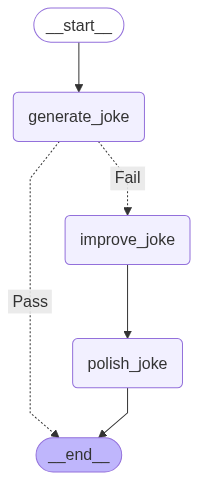

In [19]:
# Visualizamos el workflow
display(Image(chain.get_graph().draw_mermaid_png()))

### LLamado
Ahora que hemos definido y compilado el grafo siguiendo los pasos anteriores, ya podemos invocarlo para ejecutar el flujo de trabajo y obtener resultados.


In [22]:
# Invocar
state = chain.invoke({"topic": "aviones"})

print("Chiste incial:")
print(state["joke"])
print("\n--- --- ---\n")


if "improved_joke" in state:
    print("Chiste mejorado:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Chiste final:")
    print(state["final_joke"])
else:
    print("El chiste no necesitó ser mejorado!")

Chiste incial:
¿Por qué el avión se rompió?
Porque tenía una grieta en él.

--- --- ---

Chiste mejorado:
Aquí hay algunas versiones más divertidas del chiste usando juegos de palabras:

**Versión 1 (juego de palabras simple):**

¿Por qué se rompió el avión?
¡Porque tenía una grieta y no podía soportarlo!

**Versión 2 (juego de palabras con "wing"):**

¿Por qué se rompió el avión?
¡Porque su ala derecha estaba a punto de salir volando y todo el avión se estaba deshaciendo!

**Versión 3 (juego de palabras con "fuselage"):**

¿Por qué se rompió el avión?
¡Porque tenía problemas de fuselaje y se partió en dos!


**Versión 4 (juego de palabras con "plane"):**

¿Por qué se rompió el avión?
¡Porque no estaba muy bien plane...ado!

**Versión 5 (juego de palabras con "terminal"):**

¿Por qué se rompió el avión?
¡Porque estaba en una condición terminal!


**Versión 6 (un poco más larga):**

Un hombre entra a una tienda de reparación de aviones y pregunta: "¿Puedes arreglar mi avión?"
El mecánic